# Edge detection

## Edge detection of image

In [4]:
# !pip install opencv-python

1.  **Gradient based edge detection** :  
This method find edges by looking for the maximum and minimum in the first-order derivations in the digital image.
1.1. **Sobel Operator**

In [5]:
import cv2
import numpy as np
from scipy import ndimage


In [10]:
for i in range(1,25):
    image=cv2.imread(f'kodak/kodim{i:02d}.png',0)
    src = cv2.GaussianBlur(image,(5,5),0)
    sobelx = cv2.Sobel(src=src, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis, detects vetical edges
    sobely = cv2.Sobel(src=src, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis, detects horizontal edges
    sobelxy = cv2.Sobel(src=src, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection1
    cv2.imwrite(f"results/kodak{i:02d}sobel_vertical.png",sobelx)
    cv2.imwrite(f"results/kodak{i:02d}sobel_horizontal.png",sobely)
    cv2.imwrite(f"results/kodak{i:02d}sobel.png",sobelxy)

[ WARN:0@201.975] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


1.2. **Robert Operator**

In [15]:
roberts_cross_v = np.array( [[1, 0 ],
                             [0,-1 ]] ) # filter to detect vertical edges
  
roberts_cross_h = np.array( [[ 0, 1 ],
                             [ -1, 0 ]] ) # filter to detect horizontal edges
  
for i in range(1,25):
    img=cv2.imread(f'kodak/kodim{i:02d}.png',0)
    img = np.array(img)/255.0
    img=cv2.GaussianBlur(img,(3,3),0)
    vertical = ndimage.convolve( img, roberts_cross_v )
    horizontal = ndimage.convolve( img, roberts_cross_h )
    edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
    
    edged_img*=255
    horizontal_edge=horizontal*255
    vertical_edge=vertical*255
    
    cv2.imwrite(f"results/kodak{i:02d}roberty.png",horizontal_edge)
    cv2.imwrite(f"results/kodak{i:02d}robertx.png",vertical_edge)
    cv2.imwrite(f"results/kodak{i:02d}robert.png",edged_img)

2. **Gaussian Based edge detector**  
2.1. **Cany edge detector**

In [17]:
for i in range(1,25):
    img=cv2.imread(f'kodak/kodim{i:02d}.png',0)
    img=cv2.GaussianBlur(img,(3,3),0)
    edges = cv2.Canny(img,100,200)
    cv2.imwrite(f"results/kodak{i:02d}canny.png",edges)

2.2. **Laplacian of the gaussian**
We cannot calculate the second derivative directly because pixels in an image are discrete. The most common filters to compute the second derivatives are :  

2.2.1. $$\left(\begin{matrix}0&-1&0 \\ -1&4&-1 \\ 0&-1&0\end{matrix}\right)$$
2.2.2.  
$$\left(\begin{matrix}-1&-1&-1 \\ -1&8&-1 \\ -1&-1&-1\end{matrix}\right)$$

In [19]:
laplacian_op=[[0,-1,0],[-1,4,-1],[0,-1,0]]
laplacian_operator=[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]
for i in range(1,25):
    img=cv2.imread(f'kodak/kodim{i:02d}.png',0)

    img = np.array(img)/255.0
    img=cv2.GaussianBlur(img,(3,3),0)
    
    laplacian1=ndimage.convolve(img,laplacian_op)
    laplacian2=ndimage.convolve(img,laplacian_operator)
    laplacian1*=255
    laplacian2*=255
    
    cv2.imwrite(f"results/kodak{i:02d}laplacian1.png",laplacian1)
    cv2.imwrite(f"results/kodak{i:02d}laplacian2.png",laplacian2)
    

3. **Richer Convolutional Features model**

### Dataset : BSDS500 dataset
### 3.1. **HED model**

In [2]:
# import os
# import urllib.request
# import tarfile

# # # URL of the BSDS500 dataset
# # url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"

# # Directory to save the dataset
# dataset_dir = "BSDS500"

# # Create the directory if it doesn't exist
# if not os.path.exists(dataset_dir):
#     os.makedirs(dataset_dir)

# # Download the dataset
# dataset_path = os.path.join(dataset_dir, "BSR_bsds500.tgz")


# # urllib.request.urlretrieve(url, dataset_path)
# print("before extraction")
# # Extract the dataset
# with tarfile.open(dataset_path, "r:gz") as tar:
#     tar.extractall(path=dataset_dir)

# print("Dataset downloaded and extracted successfully.")


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
import os
import scipy.io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()

        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Extract the features from the VGG16 model
        self.features = vgg16.features

        # Define the side layers
        self.side1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side5 = nn.Conv2d(512, 1, kernel_size=1)

        # Define the fuse layer
        self.fuse = nn.Conv2d(5, 1, kernel_size=1)

        # Freeze the VGG16 layers
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract the feature maps
        feat1 = self.features[:4](x)
        feat2 = self.features[4:9](feat1)
        feat3 = self.features[9:16](feat2)
        feat4 = self.features[16:23](feat3)
        feat5 = self.features[23:30](feat4)

        # Apply the side layers
        side1 = self.side1(feat1)
        side2 = self.side2(feat2)
        side3 = self.side3(feat3)
        side4 = self.side4(feat4)
        side5 = self.side5(feat5)

        # Upsample the side outputs to the same size
        side2 = nn.functional.interpolate(side2, size=side1.size()[2:], mode='bilinear', align_corners=True)
        side3 = nn.functional.interpolate(side3, size=side1.size()[2:], mode='bilinear', align_corners=True)
        side4 = nn.functional.interpolate(side4, size=side1.size()[2:], mode='bilinear', align_corners=True)
        side5 = nn.functional.interpolate(side5, size=side1.size()[2:], mode='bilinear', align_corners=True)

        # Concatenate the side outputs
        fused = torch.cat((side1, side2, side3, side4, side5), dim=1)

        # Apply the fuse layer
        output = self.fuse(fused)

        # Apply sigmoid activation
        output = torch.sigmoid(output)

        return output
class EdgeDetectionDataset(Dataset):
    def __init__(self, image_paths, edge_paths, transform=None):
        self.image_paths = image_paths
        self.edge_paths = edge_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Load the .mat file and convert it to an edge map image
        mat_data = scipy.io.loadmat(self.edge_paths[idx])
        edge_map = mat_data['groundTruth'][0][0][0][0][1]  # Adjust the indices based on the structure of your .mat files
        edge_map = Image.fromarray((edge_map * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)
            edge_map = self.transform(edge_map)

        return image, edge_map


# Define the paths to the images and edge maps
dataset_path = "/home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data"
image_dir = f"{dataset_path}/images"
edge_dir = f"{dataset_path}/groundTruth"

# Define the transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


# Function to get file paths
def get_file_paths(base_dir, subdirs, extension):
    file_paths = []
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.exists(subdir_path):
            files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if f.endswith(extension)]
            file_paths.extend(files)
    return file_paths

# Get the list of image and edge map paths
subdirs = ['train', 'val']
image_paths = get_file_paths(image_dir, subdirs, '.jpg')
edge_paths = get_file_paths(edge_dir, subdirs, '.mat')

# Create the dataset
dataset = EdgeDetectionDataset(image_paths, edge_paths, transform=transform)

# Debugging steps
print(f"Number of samples in dataset: {len(dataset)}")
if len(dataset) > 0:
    print(f"Sample image path: {image_paths[0]}")
    print(f"Sample edge path: {edge_paths[0]}")
    print(f"Does the sample image exist? {os.path.exists(image_paths[0])}")
    print(f"Does the sample edge map exist? {os.path.exists(edge_paths[0])}")

    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
else:
    print("Dataset is empty. Check the paths and file formats.")

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import LambdaLR

#warmup schedule
def warmup_schedule(epoch):
    if epoch<5: # warmup for the 1st 5 epochs
        return 0.1*(epoch+1)/5
    else:
        return 1.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Initialization of the model
model = HED().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.005,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer,mode="min",factor=0.1,patience=10,verbose=True)
num_epochs = 10
# Training loops
best_loss = float("inf")
patience = 5
trigger_times = 0

#Training


for epoch in range(num_epochs):
    for images,edges in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        edges = edges.to(device)
        outputs=model(images)
        loss = criterion(outputs,edges)
        loss.backward()
        #clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        
    torch.cuda.empty_cache()
    scheduler.step(loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    if loss < best_loss:
        best_loss = loss
        trigger_times = 0
    else:
        trigger_times+=1
        if trigger_times >=patience:
            print(f"Early stopping after increase of loss {patience} times")
            break
# Save the model
torch.save(model.state_dict(), 'hed_model.pth')

# Optionally, save the entire model (architecture + weights)
torch.save(model, 'hed_model_complete.pth')

#testing
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truths
all_predictions = []
all_edges = []

# Loop through the test dataset
for images, edges in dataloader_test:
    images = images.to(device)
    edges = edges.to(device)

    with torch.no_grad():
        outputs = model(images)

    # Convert outputs to binary predictions
    predictions = (outputs > 0.5).float()

    # Flatten the predictions and edges
    predictions_flat = predictions.view(-1).cpu().numpy()
    edges_flat = edges.view(-1).cpu().numpy()

    # Store predictions and ground truths
    all_predictions.extend(predictions_flat)
    all_edges.extend(edges_flat)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_edges = np.array(all_edges)

# Ensure the data types are correct
all_predictions = all_predictions.astype(int)
all_edges = all_edges.astype(int)

# Print some predictions and ground truths for inspection
print("Sample predictions:", all_predictions[:10])
print("Sample ground truths:", all_edges[:10])

# Calculate metrics with zero_division parameter
accuracy = accuracy_score(all_edges, all_predictions)
precision = precision_score(all_edges, all_predictions, average='binary', zero_division=0)
recall = recall_score(all_edges, all_predictions, average='binary', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Number of samples in dataset: 300
Sample image path: /home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data/images/train/8049.jpg
Sample edge path: /home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data/groundTruth/train/46076.mat
Does the sample image exist? True
Does the sample edge map exist? True


/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/arofenitra/ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [3]:


for epoch in range(num_epochs):
    for images,edges in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        edges = edges.to(device)
        outputs=model(images)
        loss = criterion(outputs,edges)
        loss.backward()
        #clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        
    torch.cuda.empty_cache()
    scheduler.step(loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    if loss < best_loss:
        best_loss = loss
        trigger_times = 0
    else:
        trigger_times+=1
        if trigger_times >=patience:
            print(f"Early stopping after increase of loss {patience} times")
            break
# Save the model
torch.save(model.state_dict(), 'hed_model.pth')

# Optionally, save the entire model (architecture + weights)
torch.save(model, 'hed_model_complete.pth')




/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/arofenitra/ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Loss: 0.1093
Epoch [2/10], Loss: 0.1246
Epoch [3/10], Loss: 0.0988
Epoch [4/10], Loss: 0.0878
Epoch [5/10], Loss: 0.0934
Epoch [6/10], Loss: 0.0834
Epoch [7/10], Loss: 0.0773
Epoch [8/10], Loss: 0.0902
Epoch [9/10], Loss: 0.0916
Epoch [10/10], Loss: 0.0871


In [7]:

model = torch.load('hed_model_complete.pth', weights_only=False).to(device)
model.load_state_dict(torch.load('hed_model.pth'))
model.eval()
num_epochs = 20
for epoch in range(num_epochs):
    for images,edges in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        edges = edges.to(device)
        outputs=model(images)
        loss = criterion(outputs,edges)
        loss.backward()
        #clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        
    torch.cuda.empty_cache()
    scheduler.step(loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    if loss < best_loss:
        best_loss = loss
        trigger_times = 0
    else:
        trigger_times+=1
        if trigger_times >=patience:
            print(f"Early stopping after increase of loss {patience} times")
            break
# Save the model
torch.save(model.state_dict(), 'hed_model.pth')

# Optionally, save the entire model (architecture + weights)
torch.save(model, 'hed_model_complete.pth')


Epoch [1/20], Loss: 0.0866
Epoch [2/20], Loss: 0.0760
Epoch [3/20], Loss: 0.0926
Epoch [4/20], Loss: 0.0896
Epoch [5/20], Loss: 0.0897
Epoch [6/20], Loss: 0.0799
Epoch [7/20], Loss: 0.0933
Early stopping after increase of loss 5 times


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truths
all_predictions = []
all_edges = []

# Loop through the test dataset
for images, edges in dataloader_test:
    images = images.to(device)
    edges = edges.to(device)

    with torch.no_grad():
        outputs = model(images)

    # Convert outputs to binary predictions
    predictions = (outputs > 0.5).float()

    # Flatten the predictions and edges
    predictions_flat = predictions.view(-1).cpu().numpy()
    edges_flat = edges.view(-1).cpu().numpy()

    # Store predictions and ground truths
    all_predictions.extend(predictions_flat)
    all_edges.extend(edges_flat)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_edges = np.array(all_edges)

# Ensure the data types are correct
all_predictions = all_predictions.astype(int)
all_edges = all_edges.astype(int)

# Print some predictions and ground truths for inspection
print("Sample predictions:", all_predictions[:10])
print("Sample ground truths:", all_edges[:10])

# Calculate metrics with zero_division parameter
accuracy = accuracy_score(all_edges, all_predictions)
precision = precision_score(all_edges, all_predictions, average='binary', zero_division=0)
recall = recall_score(all_edges, all_predictions, average='binary', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Sample predictions: [0 0 0 0 0 0 0 0 0 0]
Sample ground truths: [0 0 0 0 0 0 0 0 0 0]
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000


Using device: cuda
Matched 200 image-edge pairs

=== Debugging .mat file structure for: /home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data/groundTruth/train/8049.mat ===
Keys in .mat file: ['__header__', '__version__', '__globals__', 'groundTruth']
groundTruth shape: (1, 5)
groundTruth type: <class 'numpy.ndarray'>
groundTruth dtype: object
First element type: <class 'numpy.ndarray'>
First element dtype: [('Segmentation', 'O'), ('Boundaries', 'O')]
Field names: ('Segmentation', 'Boundaries')
  Segmentation: shape=(1, 1), type=<class 'numpy.ndarray'>
    First few values: [array([[1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]], dtype=uint16)]
  Boundaries: shape=(1, 1), type=<class 'numpy.ndarray'>
    First few values: [array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
    

/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sample 0: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Sample 0: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0.0/1.0
Edge tensor unique values: tensor([0., 1.])
Epoch 1/30, Batch 0, Loss: 4.7686
Sample 2: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Sample 2: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0.0/1.0
Edge tensor unique values: tensor([0., 1.])
Sample 1: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Sample 1: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0.0/1.0
Edge tensor unique values: tensor([0., 1.])
Epoch 1/30, Batch 10, Loss: 3.9093
Epoch 1/30, Batch 20, Loss: 3.8093
Sample 0: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Sample 0: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0.0/

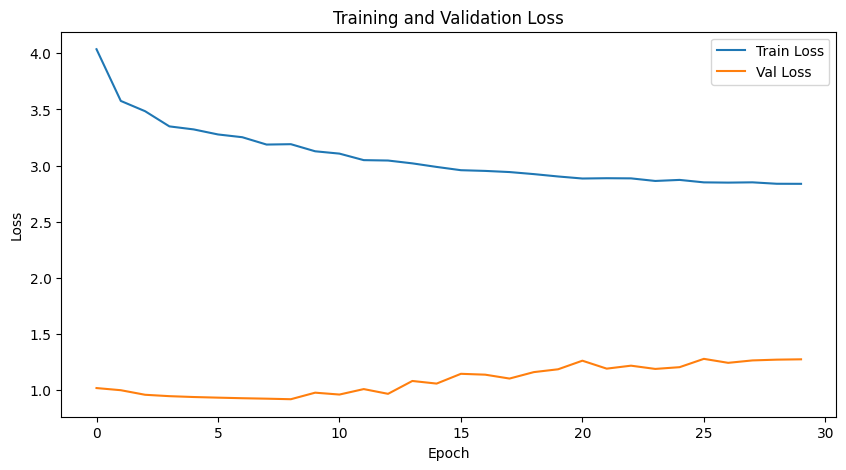

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import scipy.io
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import matplotlib.pyplot as plt

class BalancedBCELoss(nn.Module):
    """Balanced Binary Cross Entropy Loss for edge detection"""
    def __init__(self, pos_weight=None):
        super(BalancedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        
    def forward(self, pred, target):
        if self.pos_weight is None:
            # Calculate positive weight dynamically
            pos_pixels = torch.sum(target)
            neg_pixels = torch.sum(1 - target)
            if pos_pixels > 0:
                pos_weight = neg_pixels / pos_pixels
            else:
                pos_weight = 1.0
        else:
            pos_weight = self.pos_weight
            
        # Clamp predictions to avoid log(0)
        pred = torch.clamp(pred, min=1e-7, max=1-1e-7)
        
        loss = -pos_weight * target * torch.log(pred) - (1 - target) * torch.log(1 - pred)
        return torch.mean(loss)

class DiceLoss(nn.Module):
    """Dice Loss for edge detection"""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = torch.sum(pred_flat * target_flat)
        dice = (2.0 * intersection + self.smooth) / (torch.sum(pred_flat) + torch.sum(target_flat) + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined loss: Balanced BCE + Dice Loss"""
    def __init__(self, bce_weight=0.7, dice_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.bce_loss = BalancedBCELoss()
        self.dice_loss = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        
    def forward(self, pred, target):
        bce = self.bce_loss(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

class EnhancedHED(nn.Module):
    """Enhanced HED model with better architecture"""
    def __init__(self, pretrained=True):
        super(EnhancedHED, self).__init__()
        
        # Load VGG16 backbone
        vgg16 = models.vgg16(pretrained=pretrained)
        self.features = vgg16.features
        
        # Side output layers with proper initialization
        self.side1 = nn.Sequential(
            nn.Conv2d(64, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side2 = nn.Sequential(
            nn.Conv2d(128, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side3 = nn.Sequential(
            nn.Conv2d(256, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side4 = nn.Sequential(
            nn.Conv2d(512, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side5 = nn.Sequential(
            nn.Conv2d(512, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        
        # Fusion layer
        self.fuse = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )
        
        # Initialize weights
        self._initialize_weights()
        
        # Optionally freeze VGG layers
        # for param in self.features.parameters():
        #     param.requires_grad = False
    
    def _initialize_weights(self):
        for module in [self.side1, self.side2, self.side3, self.side4, self.side5, self.fuse]:
            for m in module.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        h, w = x.size()[2:]
        
        # Extract features at different scales
        feat1 = self.features[:4](x)      # 64 channels
        feat2 = self.features[4:9](feat1)  # 128 channels
        feat3 = self.features[9:16](feat2) # 256 channels
        feat4 = self.features[16:23](feat3) # 512 channels
        feat5 = self.features[23:30](feat4) # 512 channels
        
        # Side outputs
        side1 = self.side1(feat1)
        side2 = self.side2(feat2)
        side3 = self.side3(feat3)
        side4 = self.side4(feat4)
        side5 = self.side5(feat5)
        
        # Upsample to original size
        side1 = F.interpolate(side1, size=(h, w), mode='bilinear', align_corners=True)
        side2 = F.interpolate(side2, size=(h, w), mode='bilinear', align_corners=True)
        side3 = F.interpolate(side3, size=(h, w), mode='bilinear', align_corners=True)
        side4 = F.interpolate(side4, size=(h, w), mode='bilinear', align_corners=True)
        side5 = F.interpolate(side5, size=(h, w), mode='bilinear', align_corners=True)
        
        # Fusion
        fused = torch.cat([side1, side2, side3, side4, side5], dim=1)
        output = self.fuse(fused)
        
        # Apply sigmoid
        output = torch.sigmoid(output)
        
        return output, [torch.sigmoid(side1), torch.sigmoid(side2), 
                       torch.sigmoid(side3), torch.sigmoid(side4), torch.sigmoid(side5)]

class RCF(nn.Module):
    """Richer Convolutional Features for Edge Detection"""
    def __init__(self, pretrained=True):
        super(RCF, self).__init__()
        
        # VGG16 backbone
        vgg16 = models.vgg16(pretrained=pretrained)
        self.features = vgg16.features
        
        # RCF blocks for multi-scale feature extraction
        self.rcf_block1 = self._make_rcf_block(64, [1, 2, 3])
        self.rcf_block2 = self._make_rcf_block(128, [1, 2, 3])
        self.rcf_block3 = self._make_rcf_block(256, [1, 2, 3, 5])
        self.rcf_block4 = self._make_rcf_block(512, [1, 2, 3, 5])
        self.rcf_block5 = self._make_rcf_block(512, [1, 2, 3, 5])
        
        # Side outputs
        self.side1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side5 = nn.Conv2d(512, 1, kernel_size=1)
        
        # Fusion
        self.fuse = nn.Conv2d(5, 1, kernel_size=1)
        
        self._initialize_weights()
    
    def _make_rcf_block(self, in_channels, dilations):
        layers = []
        for dilation in dilations:
            layers.append(nn.Conv2d(in_channels, in_channels, 
                                  kernel_size=3, padding=dilation, dilation=dilation))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        h, w = x.size()[2:]
        
        # Extract features
        feat1 = self.features[:4](x)
        feat2 = self.features[4:9](feat1)
        feat3 = self.features[9:16](feat2)
        feat4 = self.features[16:23](feat3)
        feat5 = self.features[23:30](feat4)
        
        # Apply RCF blocks
        feat1 = self.rcf_block1(feat1)
        feat2 = self.rcf_block2(feat2)
        feat3 = self.rcf_block3(feat3)
        feat4 = self.rcf_block4(feat4)
        feat5 = self.rcf_block5(feat5)
        
        # Side outputs
        side1 = self.side1(feat1)
        side2 = self.side2(feat2)
        side3 = self.side3(feat3)
        side4 = self.side4(feat4)
        side5 = self.side5(feat5)
        
        # Upsample
        side1 = F.interpolate(side1, size=(h, w), mode='bilinear', align_corners=True)
        side2 = F.interpolate(side2, size=(h, w), mode='bilinear', align_corners=True)
        side3 = F.interpolate(side3, size=(h, w), mode='bilinear', align_corners=True)
        side4 = F.interpolate(side4, size=(h, w), mode='bilinear', align_corners=True)
        side5 = F.interpolate(side5, size=(h, w), mode='bilinear', align_corners=True)
        
        # Fusion
        fused = torch.cat([side1, side2, side3, side4, side5], dim=1)
        output = self.fuse(fused)
        
        return torch.sigmoid(output)

class ImprovedEdgeDetectionDataset(Dataset):
    """Improved dataset with better error handling and preprocessing"""
    def __init__(self, image_paths, edge_paths, transform=None, augment=False):
        # Filter and match files properly
        self.image_paths, self.edge_paths = self._match_files(image_paths, edge_paths)
        self.transform = transform
        self.augment = augment
        
        # Data augmentation transforms
        if augment:
            self.aug_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
            ])
        
        # Debug: Print structure of first .mat file
        if len(self.edge_paths) > 0:
            self._debug_mat_structure(self.edge_paths[0])
    
    def _debug_mat_structure(self, mat_path):
        """Debug function to print .mat file structure"""
        try:
            mat_data = scipy.io.loadmat(mat_path)
            print(f"\n=== Debugging .mat file structure for: {mat_path} ===")
            print(f"Keys in .mat file: {list(mat_data.keys())}")
            
            if 'groundTruth' in mat_data:
                gt = mat_data['groundTruth']
                print(f"groundTruth shape: {gt.shape}")
                print(f"groundTruth type: {type(gt)}")
                print(f"groundTruth dtype: {gt.dtype}")
                
                if gt.size > 0:
                    first_element = gt[0, 0]
                    print(f"First element type: {type(first_element)}")
                    
                    # Check if it's a structured array
                    if hasattr(first_element, 'dtype'):
                        print(f"First element dtype: {first_element.dtype}")
                        if hasattr(first_element.dtype, 'names') and first_element.dtype.names:
                            print(f"Field names: {first_element.dtype.names}")
                            for field in first_element.dtype.names:
                                field_data = first_element[field]
                                print(f"  {field}: shape={getattr(field_data, 'shape', 'N/A')}, "
                                      f"type={type(field_data)}")
                                if hasattr(field_data, 'shape') and len(field_data.shape) > 0:
                                    print(f"    First few values: {field_data.flat[:5] if field_data.size > 0 else 'Empty'}")
                    
                    # Try different access patterns
                    try:
                        boundaries = first_element['Boundaries'][0, 0]
                        print(f"Boundaries shape: {boundaries.shape}")
                        print(f"Boundaries dtype: {boundaries.dtype}")
                        print(f"Boundaries min/max: {boundaries.min()}/{boundaries.max()}")
                        print(f"Unique values in Boundaries: {np.unique(boundaries)}")
                    except:
                        print("Could not access Boundaries field")
                        
                    try:
                        segmentation = first_element['Segmentation'][0, 0]
                        print(f"Segmentation shape: {segmentation.shape}")
                    except:
                        print("Could not access Segmentation field")
            
            print("=== End debug ===\n")
        except Exception as e:
            print(f"Error debugging .mat file: {e}")
    
    def _match_files(self, image_paths, edge_paths):
        """Match image and edge files by filename"""
        image_dict = {}
        edge_dict = {}
        
        # Create dictionaries with base filenames
        for img_path in image_paths:
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            image_dict[base_name] = img_path
        
        for edge_path in edge_paths:
            base_name = os.path.splitext(os.path.basename(edge_path))[0]
            edge_dict[base_name] = edge_path
        
        # Find matching pairs
        matched_images = []
        matched_edges = []
        
        for base_name in image_dict.keys():
            if base_name in edge_dict:
                matched_images.append(image_dict[base_name])
                matched_edges.append(edge_dict[base_name])
        
        print(f"Matched {len(matched_images)} image-edge pairs")
        return matched_images, matched_edges
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            # Load image
            image = Image.open(self.image_paths[idx]).convert('RGB')
            
            # Load edge map from .mat file
            mat_data = scipy.io.loadmat(self.edge_paths[idx])
            
            # Handle BSDS500 .mat file structure
            if 'groundTruth' in mat_data:
                gt_data = mat_data['groundTruth']
                first_element = gt_data[0, 0]
                
                # Access the Boundaries field
                if hasattr(first_element.dtype, 'names') and 'Boundaries' in first_element.dtype.names:
                    edge_map = first_element['Boundaries'][0, 0]
                else:
                    # Fallback access pattern
                    edge_map = gt_data[0, 0][0][0][1]
            else:
                # Try direct access for other formats
                keys = [k for k in mat_data.keys() if not k.startswith('__')]
                edge_map = mat_data[keys[0]]
            
            # Debug print for first few samples
            if idx < 3:
                print(f"Sample {idx}: Edge map shape: {edge_map.shape}, "
                      f"dtype: {edge_map.dtype}, min/max: {edge_map.min()}/{edge_map.max()}")
            
            # Ensure binary values (0 or 1)
            edge_map = (edge_map > 0).astype(np.float32)
            
            # Convert to PIL Image
            edge_map_pil = Image.fromarray((edge_map * 255).astype(np.uint8), mode='L')
            
            # Apply augmentation if specified
            if self.augment and hasattr(self, 'aug_transform'):
                # Apply same transform to both image and edge map
                seed = np.random.randint(2147483647)
                torch.manual_seed(seed)
                image = self.aug_transform(image)
                torch.manual_seed(seed)
                edge_map_pil = self.aug_transform(edge_map_pil)
            
            # Apply main transforms
            if self.transform:
                image = self.transform(image)
                edge_map_tensor = self.transform(edge_map_pil)
            else:
                # Convert to tensor manually if no transform
                image = transforms.ToTensor()(image)
                edge_map_tensor = transforms.ToTensor()(edge_map_pil)
                
            # Ensure edge map is single channel and binary
            if edge_map_tensor.shape[0] == 3:
                edge_map_tensor = edge_map_tensor[0:1]  # Take first channel
            
            # Ensure binary values (0 or 1) in tensor
            edge_map_tensor = (edge_map_tensor > 0.5).float()
            
            # Debug print for first few samples
            if idx < 3:
                print(f"Sample {idx}: Final tensor shapes - Image: {image.shape}, "
                      f"Edge: {edge_map_tensor.shape}")
                print(f"Edge tensor min/max: {edge_map_tensor.min()}/{edge_map_tensor.max()}")
                print(f"Edge tensor unique values: {torch.unique(edge_map_tensor)}")
            
            return image, edge_map_tensor
            
        except Exception as e:
            print(f"Error loading sample {idx} from {self.edge_paths[idx]}: {e}")
            # Return a dummy sample with proper binary values
            if self.transform:
                dummy_img = torch.zeros(3, 320, 320)  # Match transform size
                dummy_edge = torch.zeros(1, 320, 320)
            else:
                dummy_img = torch.zeros(3, 256, 256)
                dummy_edge = torch.zeros(1, 256, 256)
            return dummy_img, dummy_edge

def calculate_edge_metrics(predictions, targets, threshold=0.5):
    """Calculate comprehensive metrics for edge detection"""
    # Debug prints
    print(f"Predictions shape: {predictions.shape}, dtype: {predictions.dtype}")
    print(f"Targets shape: {targets.shape}, dtype: {targets.dtype}")
    print(f"Predictions min/max: {predictions.min():.4f}/{predictions.max():.4f}")
    print(f"Targets min/max: {targets.min():.4f}/{targets.max():.4f}")
    print(f"Predictions unique values: {torch.unique(predictions)[:10]}")  # Show first 10
    print(f"Targets unique values: {torch.unique(targets)}")
    
    # Ensure predictions are in [0, 1] range and apply threshold
    predictions = torch.clamp(predictions, 0, 1)
    pred_binary = (predictions > threshold).float()
    
    # Ensure targets are binary (0 or 1)
    targets_binary = (targets > 0.5).float()
    
    # Flatten tensors
    pred_flat = pred_binary.view(-1).cpu().numpy().astype(int)
    target_flat = targets_binary.view(-1).cpu().numpy().astype(int)
    
    # Debug prints for flattened arrays
    print(f"Flattened predictions shape: {pred_flat.shape}, dtype: {pred_flat.dtype}")
    print(f"Flattened targets shape: {target_flat.shape}, dtype: {target_flat.dtype}")
    print(f"Unique pred_flat values: {np.unique(pred_flat)}")
    print(f"Unique target_flat values: {np.unique(target_flat)}")
    
    # Calculate metrics with proper error handling
    try:
        accuracy = accuracy_score(target_flat, pred_flat)
        precision = precision_score(target_flat, pred_flat, zero_division=0)
        recall = recall_score(target_flat, pred_flat, zero_division=0)
        f1 = f1_score(target_flat, pred_flat, zero_division=0)
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'edge_ratio': 0.0
        }
    
    # Edge-specific metrics
    edge_pixels = np.sum(target_flat)
    total_pixels = len(target_flat)
    edge_ratio = edge_pixels / total_pixels if total_pixels > 0 else 0.0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'edge_ratio': edge_ratio
    }

def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    """Enhanced training function"""
    
    # Loss function and optimizer
    criterion = CombinedLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_loss = float('inf')
    best_f1 = 0.0
    patience = 10
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (images, edges) in enumerate(train_loader):
            images, edges = images.to(device), edges.to(device)
            
            optimizer.zero_grad()
            
            if isinstance(model, EnhancedHED):
                outputs, side_outputs = model(images)
                loss = criterion(outputs, edges)
                # Add loss from side outputs
                for side_out in side_outputs:
                    loss += 0.5 * criterion(side_out, edges)
            else:
                outputs = model(images)
                loss = criterion(outputs, edges)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for images, edges in val_loader:
                images, edges = images.to(device), edges.to(device)
                
                if isinstance(model, EnhancedHED):
                    outputs, _ = model(images)
                else:
                    outputs = model(images)
                
                loss = criterion(outputs, edges)
                val_loss += loss.item()
                
                all_predictions.append(outputs.cpu())
                all_targets.append(edges.cpu())
        
        # Calculate metrics
        all_predictions = torch.cat(all_predictions, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        metrics = calculate_edge_metrics(all_predictions, all_targets)
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'  Metrics - Acc: {metrics["accuracy"]:.4f}, Prec: {metrics["precision"]:.4f}, '
              f'Rec: {metrics["recall"]:.4f}, F1: {metrics["f1"]:.4f}')
        print(f'  Edge Ratio: {metrics["edge_ratio"]:.4f}')
        
        # Learning rate scheduling
        scheduler.step()
        
        # Early stopping based on F1 score
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_edge_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    return train_losses, val_losses

# Example usage
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((320, 320)),  # Larger size for better edge detection
        transforms.ToTensor(),
    ])
    
    # Dataset paths (update these paths)
    dataset_path = "/home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data"
    
    # Helper function to get file paths
    def get_file_paths(base_dir, subdirs, extension):
        file_paths = []
        for subdir in subdirs:
            subdir_path = os.path.join(base_dir, subdir)
            if os.path.exists(subdir_path):
                files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) 
                        if f.endswith(extension)]
                file_paths.extend(files)
        return file_paths
    
    # Get file paths
    train_image_paths = get_file_paths(f"{dataset_path}/images", ['train'], '.jpg')
    train_edge_paths = get_file_paths(f"{dataset_path}/groundTruth", ['train'], '.mat')
    
    val_image_paths = get_file_paths(f"{dataset_path}/images", ['val'], '.jpg')
    val_edge_paths = get_file_paths(f"{dataset_path}/groundTruth", ['val'], '.mat')
    
    # Create datasets
    train_dataset = ImprovedEdgeDetectionDataset(
        train_image_paths, train_edge_paths, transform=transform, augment=True
    )
    val_dataset = ImprovedEdgeDetectionDataset(
        val_image_paths, val_edge_paths, transform=transform, augment=False
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Val dataset size: {len(val_dataset)}")
    
    # Initialize model
    model = EnhancedHED(pretrained=True).to(device)
    # Alternative: model = RCF(pretrained=True).to(device)
    
    # Train the model
    if len(train_dataset) > 0 and len(val_dataset) > 0:
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, num_epochs=30, device=device
        )
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.savefig('training_curves.png')
        plt.show()
    else:
        print("Dataset loading failed. Please check your paths and data structure.")

In [20]:
print("train losses: ",train_losses)
print("val losses: ",val_losses)
print(f"all_predictions: {all_targets}")

train losses:  [4.036016368865967, 3.5754965019226073, 3.483959770202637, 3.348723068237305, 3.3217783164978028, 3.276874237060547, 3.25227707862854, 3.1868397998809814, 3.190161256790161, 3.1270035457611085, 3.1061500835418703, 3.048146896362305, 3.0446151161193846, 3.0194329738616945, 2.9876153659820557, 2.958459596633911, 2.952148923873901, 2.9419748973846436, 2.9236677837371827, 2.9025490951538084, 2.8844133377075196, 2.887077627182007, 2.8857022190093993, 2.8626464557647706, 2.872003335952759, 2.8501336860656736, 2.847892065048218, 2.8503321838378906, 2.8376573276519776, 2.83707709312439]
val losses:  [1.0180403315103972, 0.998884563262646, 0.9582499999266404, 0.9458614266835726, 0.9382191071143517, 0.932598141523508, 0.927541576899015, 0.9234705338111291, 0.9186073037294241, 0.9769436625333933, 0.9602459256465619, 1.0088509596311128, 0.9666159611481887, 1.081117643759801, 1.0578740009894738, 1.1449610728483934, 1.137281821324275, 1.1026951991594756, 1.1600271784342253, 1.18528437

NameError: name 'all_targets' is not defined

Using device: cuda
Matched 200 image-edge pairs

=== Debugging .mat file structure for: /home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data/groundTruth/train/8049.mat ===
Keys in .mat file: ['__header__', '__version__', '__globals__', 'groundTruth']
groundTruth shape: (1, 5)
groundTruth type: <class 'numpy.ndarray'>
groundTruth dtype: object
First element type: <class 'numpy.ndarray'>
First element dtype: [('Segmentation', 'O'), ('Boundaries', 'O')]
Field names: ('Segmentation', 'Boundaries')
  Segmentation: shape=(1, 1), type=<class 'numpy.ndarray'>
    First few values: [array([[1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]], dtype=uint16)]
  Boundaries: shape=(1, 1), type=<class 'numpy.ndarray'>
    First few values: [array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
    

/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arofenitra/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100, Batch 0, Loss: 4.9052
Sample 2: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Sample 2: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0.0/1.0
Edge tensor unique values: tensor([0., 1.])
Epoch 1/100, Batch 10, Loss: 3.9551
Sample 1: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Sample 1: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0.0/1.0
Sample 0: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Edge tensor unique values: tensor([0., 1.])
Sample 0: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0.0/1.0
Edge tensor unique values: tensor([0., 1.])
Epoch 1/100, Batch 20, Loss: 4.0632
Sample 0: Edge map shape: (321, 481), dtype: uint8, min/max: 0/1
Sample 0: Final tensor shapes - Image: torch.Size([3, 320, 320]), Edge: torch.Size([1, 320, 320])
Edge tensor min/max: 0

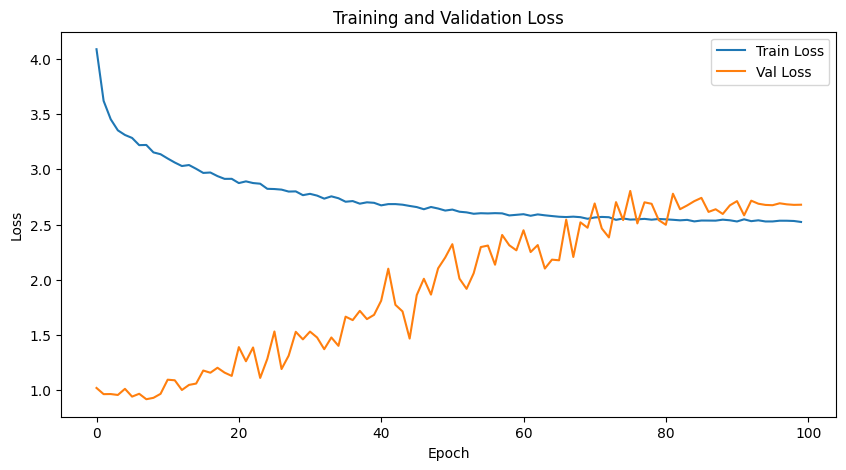

In [22]:


def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda',train_losses=train_losses,val_losses=val_losses):
    """Enhanced training function"""
    
    # Loss function and optimizer
    criterion = CombinedLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_loss = float('inf')
    best_f1 = 0.0
    patience = 10
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (images, edges) in enumerate(train_loader):
            images, edges = images.to(device), edges.to(device)
            
            optimizer.zero_grad()
            
            if isinstance(model, EnhancedHED):
                outputs, side_outputs = model(images)
                loss = criterion(outputs, edges)
                # Add loss from side outputs
                for side_out in side_outputs:
                    loss += 0.5 * criterion(side_out, edges)
            else:
                outputs = model(images)
                loss = criterion(outputs, edges)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for images, edges in val_loader:
                images, edges = images.to(device), edges.to(device)
                
                if isinstance(model, EnhancedHED):
                    outputs, _ = model(images)
                else:
                    outputs = model(images)
                
                loss = criterion(outputs, edges)
                val_loss += loss.item()
                
                all_predictions.append(outputs.cpu())
                all_targets.append(edges.cpu())
        
        # Calculate metrics
        all_predictions = torch.cat(all_predictions, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        metrics = calculate_edge_metrics(all_predictions, all_targets)
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'  Metrics - Acc: {metrics["accuracy"]:.4f}, Prec: {metrics["precision"]:.4f}, '
              f'Rec: {metrics["recall"]:.4f}, F1: {metrics["f1"]:.4f}')
        print(f'  Edge Ratio: {metrics["edge_ratio"]:.4f}')
        
        # Learning rate scheduling
        scheduler.step()
        
        # Early stopping based on F1 score
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_edge_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= 3*patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    return train_losses, val_losses

# Example usage
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((320, 320)),  # Larger size for better edge detection
        transforms.ToTensor(),
    ])
    
    # Dataset paths (update these paths)
    dataset_path = "/home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data"
    
    # Helper function to get file paths
    def get_file_paths(base_dir, subdirs, extension):
        file_paths = []
        for subdir in subdirs:
            subdir_path = os.path.join(base_dir, subdir)
            if os.path.exists(subdir_path):
                files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) 
                        if f.endswith(extension)]
                file_paths.extend(files)
        return file_paths
    
    # Get file paths
    train_image_paths = get_file_paths(f"{dataset_path}/images", ['train'], '.jpg')
    train_edge_paths = get_file_paths(f"{dataset_path}/groundTruth", ['train'], '.mat')
    
    val_image_paths = get_file_paths(f"{dataset_path}/images", ['val'], '.jpg')
    val_edge_paths = get_file_paths(f"{dataset_path}/groundTruth", ['val'], '.mat')
    
    # Create datasets
    train_dataset = ImprovedEdgeDetectionDataset(
        train_image_paths, train_edge_paths, transform=transform, augment=True
    )
    val_dataset = ImprovedEdgeDetectionDataset(
        val_image_paths, val_edge_paths, transform=transform, augment=False
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Val dataset size: {len(val_dataset)}")
    
    # Initialize model
    model = EnhancedHED(pretrained=True).to(device)
    # Alternative: model = RCF(pretrained=True).to(device)
    
    # Train the model
    if len(train_dataset) > 0 and len(val_dataset) > 0:
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, num_epochs=100, device=device
        )
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.savefig('training_curves.png')
        plt.show()
    else:
        print("Dataset loading failed. Please check your paths and data structure.")

In [28]:
model.load_state_dict(torch.load('best_edge_model.pth'))
test_loss = 0.0
all_predictions = []
all_targets = []
test_losses = []
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((320, 320)),  # Larger size for better edge detection
    transforms.ToTensor(),
])

# Dataset paths (update these paths)
dataset_path = "/home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data"

# Helper function to get file paths
def get_file_paths(base_dir, subdirs, extension):
    file_paths = []
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.exists(subdir_path):
            files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) 
                    if f.endswith(extension)]
            file_paths.extend(files)
    return file_paths

# Get file paths
test_image_paths = get_file_paths(f"{dataset_path}/images", ['test'], '.jpg')
test_edge_paths = get_file_paths(f"{dataset_path}/groundTruth", ['test'], '.mat')



# Create datasets
test_dataset = ImprovedEdgeDetectionDataset(
    test_image_paths, test_edge_paths, transform=transform, augment=True
)

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)
print(f"test dataset size: {len(test_dataset)}")

with torch.no_grad():
    for images, edges in test_loader:
        images, edges = images.to(device), edges.to(device)
        
        if isinstance(model, EnhancedHED):
            outputs, _ = model(images)
        else:
            outputs = model(images)
        
        loss = criterion(outputs, edges)
        test_loss += loss.item()
        
        all_predictions.append(outputs.cpu())
        all_targets.append(edges.cpu())

# Calculate metrics
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)
metricstest = calculate_edge_metrics(all_predictions, all_targets)

avg_test_loss = test_loss / len(test_loader)

test_losses.append(avg_test_loss)

print(f'Epoch {epoch+1}/{num_epochs}:')
print(f'  Train Loss: {avg_test_loss:.4f}')
print(f'  Metrics test - Acc: {metricstest["accuracy"]:.4f}, Prec: {metricstest["precision"]:.4f}, '
      f'Rec: {metricstest["recall"]:.4f}, F1: {metricstest["f1"]:.4f}')
print(f'  Edge Ratio: {metricstest["edge_ratio"]:.4f}')

Using device: cuda
Matched 200 image-edge pairs

=== Debugging .mat file structure for: /home/arofenitra/deep-learning/project/BSDS500/BSR/BSDS500/data/groundTruth/test/77062.mat ===
Keys in .mat file: ['__header__', '__version__', '__globals__', 'groundTruth']
groundTruth shape: (1, 8)
groundTruth type: <class 'numpy.ndarray'>
groundTruth dtype: object
First element type: <class 'numpy.ndarray'>
First element dtype: [('Segmentation', 'O'), ('Boundaries', 'O')]
Field names: ('Segmentation', 'Boundaries')
  Segmentation: shape=(1, 1), type=<class 'numpy.ndarray'>
    First few values: [array([[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [8, 8, 8, ..., 2, 2, 2],
        [8, 8, 8, ..., 2, 2, 2],
        [8, 8, 8, ..., 2, 2, 2]], dtype=uint16)]
  Boundaries: shape=(1, 1), type=<class 'numpy.ndarray'>
    First few values: [array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
    

In [39]:
print(f"Shape of outputs is : {outputs.shape}")
print(f"len of side_outputs is {len(side_outputs)} in which each of the has {side_outputs[0].shape} shape")
print(f"Outputs is \n{outputs}\nSide outputs is {side_outputs}")

Shape of outputs is : torch.Size([8, 1, 320, 320])
len of side_outputs is 5 in which each of the has torch.Size([8, 1, 320, 320]) shape
Outputs is 
tensor([[[[4.5203e-02, 4.5205e-03, 3.2299e-03,  ..., 2.5842e-03,
           6.9171e-03, 2.6781e-02],
          [2.7205e-03, 1.0036e-04, 4.4348e-05,  ..., 3.8910e-05,
           2.1536e-04, 2.1963e-03],
          [1.1464e-03, 1.3727e-05, 5.3057e-06,  ..., 2.4420e-06,
           2.2658e-05, 3.8098e-04],
          ...,
          [5.7528e-02, 1.0333e-02, 6.2392e-03,  ..., 6.5176e-07,
           2.4255e-06, 1.4855e-04],
          [8.6211e-02, 1.3148e-02, 7.1136e-03,  ..., 1.6724e-06,
           6.9985e-06, 3.6886e-04],
          [1.7569e-01, 4.3249e-02, 2.9101e-02,  ..., 2.0686e-04,
           5.7931e-04, 7.4417e-03]]],


        [[[1.1079e-01, 3.5783e-02, 8.6861e-03,  ..., 6.0794e-08,
           1.7329e-06, 1.0906e-04],
          [3.4298e-02, 4.1111e-03, 5.3872e-04,  ..., 2.7964e-12,
           5.0045e-10, 2.0714e-07],
          [2.5478e-02, 2.

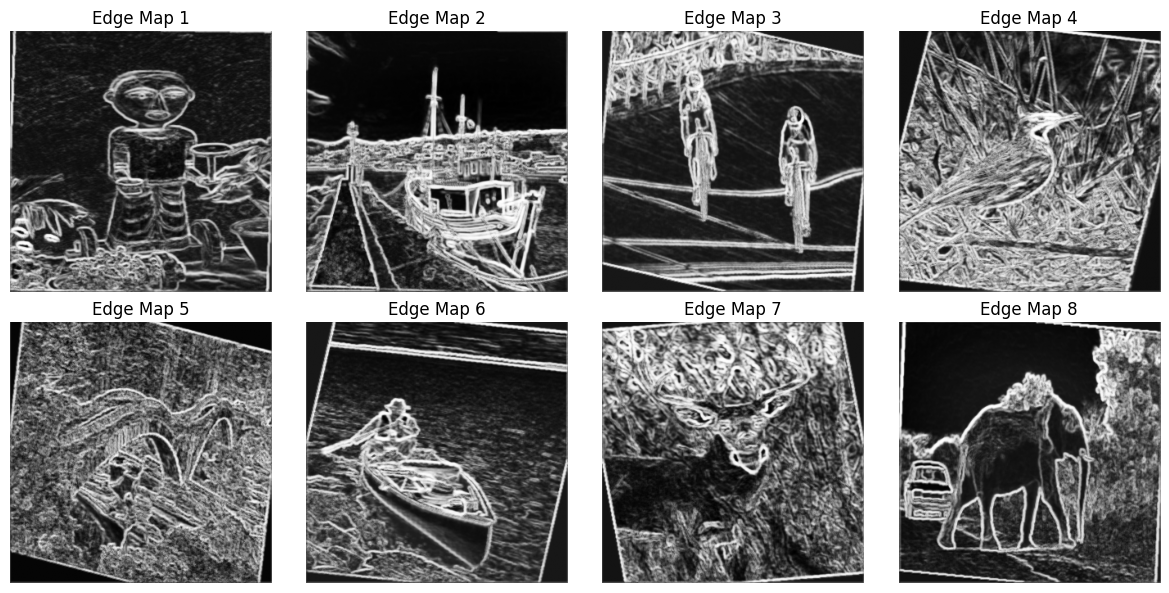

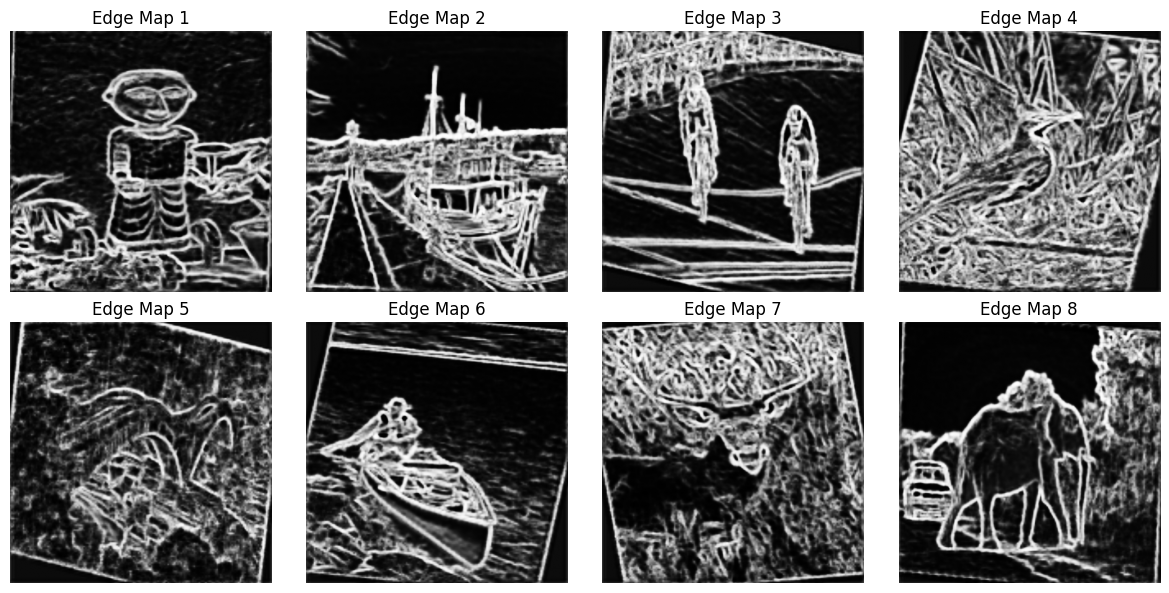

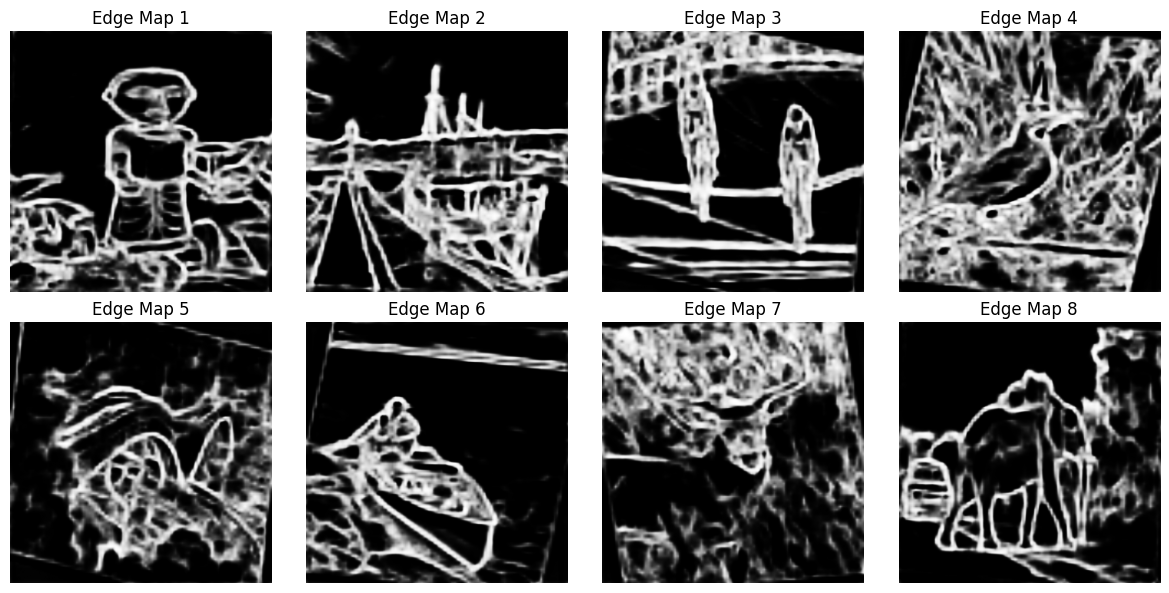

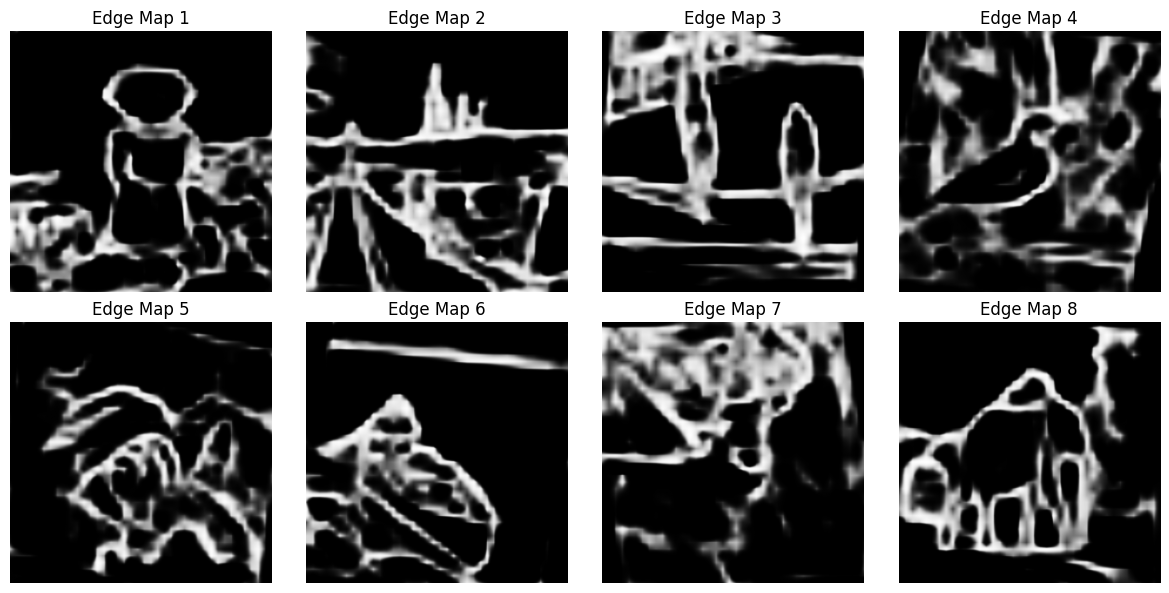

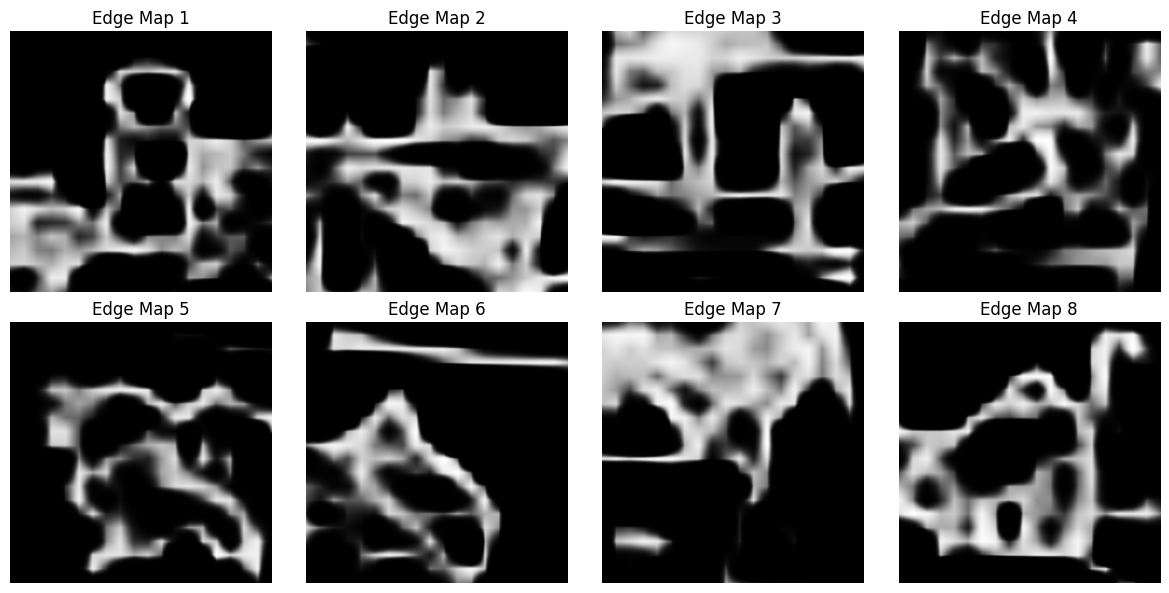

In [47]:
import matplotlib.pyplot as plt 
# edge_maps = outputs.detach().cpu().numpy()
# # Plot each edge map
# num_edge_maps = edge_maps.shape[0]
# fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Create a 2x4 grid of subplots

# for i in range(num_edge_maps):
#     ax = axes[i // 4, i % 4]  # Select the appropriate subplot
#     edge_map = edge_maps[i, 0, :, :]  # Extract the i-th edge map
#     ax.imshow(edge_map, cmap='gray')  # Plot the edge map in grayscale
#     ax.set_title(f'Edge Map {i+1}')
#     ax.axis('off')  # Turn off axis labels

# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()  # Display the plot
edge_side_outputs = side_outputs
for j in range(len(edge_side_outputs)):
    sides = edge_side_outputs[j].detach().cpu().numpy()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Create a 2x4 grid of subplots
    for i in range(num_edge_maps):
        
        ax = axes[i // 4, i % 4]  # Select the appropriate subplot
        edge_map = sides[i, 0, :, :]  # Extract the i-th edge map
        ax.imshow(edge_map, cmap='gray')  # Plot the edge map in grayscale
        ax.set_title(f'Edge Map {i+1}')
        ax.axis('off')  # Turn off axis labels
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

In [62]:
from PIL import Image
from torchvision.transforms import Compose
from torchvision import transforms
for i in range(1,25):
    
    image=Image.open(f'kodak/kodim{i:02d}.png').convert("RGB")
    # Define the preprocessing transform
    transform = Compose([
        transforms.Resize((320, 320)),  # Resize to match the input size used during training
        transforms.ToTensor(),  # Convert to tensor
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    # Run inference
    with torch.no_grad():
        output, side_outputs = model(image_tensor)
    
    # Convert the output tensor to a NumPy array
    output_numpy = output[0,0].cpu().numpy()
    output_pil = Image.fromarray((output_numpy*255).astype(np.uint8),mode="L")
    output_pil.save(f"results/kodak{i:02d}HED.png")

## Ideas of Edge detection in videos:
1. *Video to frames conversion*: Convert video into a series of frames
2. *Edge detection on frames*: Apply edge detection on each frame
3. *Post-processing*: Apply post-processing techniques to enhance the edges
3. *Frame to video conversion*: Combine the edge-detected frames back into a video

In [77]:
from compressai.zoo import models

In [78]:
print(models)

{'stf': <class 'compressai.models.stf.SymmetricalTransFormer'>, 'cnn': <class 'compressai.models.cnn.WACNN'>}


In [80]:
!wget https://motchallenge.net/data/MOT17.zip

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/arofenitra/.wget-hsts'. HSTS will be disabled.
--2025-05-26 15:38:29--  https://motchallenge.net/data/MOT17.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5860214001 (5.5G) [application/zip]
Saving to: ‘MOT17.zip’

MOT17.zip           100%[===================>]   5.46G  18.6MB/s    in 4m 2s   

2025-05-26 15:42:31 (23.1 MB/s) - ‘MOT17.zip’ saved [5860214001/5860214001]



In [81]:
!ls

BSDS500		     edges_detection.ipynb   kodak
MOT17.zip	     hed_model.pth	     results
best_edge_model.pth  hed_model_complete.pth  training_curves.png


In [82]:
!unzip MOT17.zip

Archive:  MOT17.zip
   creating: MOT17/
   creating: MOT17/test/
   creating: MOT17/test/MOT17-14-SDP/
   creating: MOT17/test/MOT17-14-SDP/det/
  inflating: MOT17/test/MOT17-14-SDP/det/det.txt  
  inflating: MOT17/test/MOT17-14-SDP/seqinfo.ini  
   creating: MOT17/test/MOT17-14-SDP/img1/
  inflating: MOT17/test/MOT17-14-SDP/img1/000608.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000634.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000152.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000146.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000620.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000191.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000185.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000378.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000350.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000436.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000422.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000344.jpg  
  inflating: MOT17/test/MOT17-14-SDP/img1/000393.j

In [85]:
!ls

BSDS500    best_edge_model.pth	  hed_model_complete.pth  training_curves.png
MOT17	   edges_detection.ipynb  kodak
MOT17.zip  hed_model.pth	  results


In [94]:
PATH = []
for dirname,_,filenames in os.walk("MOT17"):
    
    paths = []
    if "img1" in dirname:
        for filename in filenames:
            if "jpg" in filename:
                paths+=[os.path.join(dirname,filename)]

                
    paths = sorted(paths)
    if len(paths)>10:
        PATH+=[paths]
print(len(PATH))
for i in range(len(PATH)):
    path=PATH[i][0]
    print(i,path.split('/')[-4:-2])

            

42
0 ['train', 'MOT17-05-DPM']
1 ['train', 'MOT17-13-SDP']
2 ['train', 'MOT17-09-FRCNN']
3 ['train', 'MOT17-09-DPM']
4 ['train', 'MOT17-02-SDP']
5 ['train', 'MOT17-11-SDP']
6 ['train', 'MOT17-05-SDP']
7 ['train', 'MOT17-02-DPM']
8 ['train', 'MOT17-04-FRCNN']
9 ['train', 'MOT17-02-FRCNN']
10 ['train', 'MOT17-10-SDP']
11 ['train', 'MOT17-11-DPM']
12 ['train', 'MOT17-05-FRCNN']
13 ['train', 'MOT17-10-DPM']
14 ['train', 'MOT17-11-FRCNN']
15 ['train', 'MOT17-09-SDP']
16 ['train', 'MOT17-13-DPM']
17 ['train', 'MOT17-04-DPM']
18 ['train', 'MOT17-10-FRCNN']
19 ['train', 'MOT17-04-SDP']
20 ['train', 'MOT17-13-FRCNN']
21 ['test', 'MOT17-12-DPM']
22 ['test', 'MOT17-03-DPM']
23 ['test', 'MOT17-06-FRCNN']
24 ['test', 'MOT17-08-FRCNN']
25 ['test', 'MOT17-07-SDP']
26 ['test', 'MOT17-06-SDP']
27 ['test', 'MOT17-08-DPM']
28 ['test', 'MOT17-12-FRCNN']
29 ['test', 'MOT17-08-SDP']
30 ['test', 'MOT17-14-SDP']
31 ['test', 'MOT17-14-FRCNN']
32 ['test', 'MOT17-03-FRCNN']
33 ['test', 'MOT17-07-FRCNN']
34 ['tes

In [121]:
import os
print(os.getcwd())
for i in range(len(PATH)):
    path=PATH[i][0]
    a = (i,path.split('/'))
    # a = f"{a[1][0]}_HED/{a[1][1]}/{a[1][2]}"
    print(a)
    # os.makedirs(a,exist_ok=True)
    # print(os.path.exists(a))
    

    
# for i in range(1,25):
#     img=cv2.imread(f'kodak/kodim{i:02d}.png',0)
#     img=cv2.GaussianBlur(img,(3,3),0)
#     edges = cv2.Canny(img,100,200)
#     cv2.imwrite(f"results/kodak{i:02d}canny.png",edges)

/home/arofenitra/deep-learning/project
(0, ['MOT17', 'test', 'MOT17-01-DPM', 'img1', '000001.jpg'])
(1, ['MOT17', 'test', 'MOT17-01-FRCNN', 'img1', '000001.jpg'])
(2, ['MOT17', 'test', 'MOT17-01-SDP', 'img1', '000001.jpg'])
(3, ['MOT17', 'test', 'MOT17-03-DPM', 'img1', '000001.jpg'])
(4, ['MOT17', 'test', 'MOT17-03-FRCNN', 'img1', '000001.jpg'])
(5, ['MOT17', 'test', 'MOT17-03-SDP', 'img1', '000001.jpg'])
(6, ['MOT17', 'test', 'MOT17-06-DPM', 'img1', '000001.jpg'])
(7, ['MOT17', 'test', 'MOT17-06-FRCNN', 'img1', '000001.jpg'])
(8, ['MOT17', 'test', 'MOT17-06-SDP', 'img1', '000001.jpg'])
(9, ['MOT17', 'test', 'MOT17-07-DPM', 'img1', '000001.jpg'])
(10, ['MOT17', 'test', 'MOT17-07-FRCNN', 'img1', '000001.jpg'])
(11, ['MOT17', 'test', 'MOT17-07-SDP', 'img1', '000001.jpg'])
(12, ['MOT17', 'test', 'MOT17-08-DPM', 'img1', '000001.jpg'])
(13, ['MOT17', 'test', 'MOT17-08-FRCNN', 'img1', '000001.jpg'])
(14, ['MOT17', 'test', 'MOT17-08-SDP', 'img1', '000001.jpg'])
(15, ['MOT17', 'test', 'MOT17-1

In [141]:
from PIL import Image
from torchvision.transforms import Compose
from torchvision import transforms
transform = Compose([
    transforms.Resize((320, 320)),  # Resize to match the input size used during training
    transforms.ToTensor(),  # Convert to tensor
])
for i in range(len(PATH)):
    torch.cuda.empty_cache()
    for j in range(len(PATH[i])):
        path=PATH[i][j]
        a = (i,path.split('/'))
        image_num = a[1].copy()[-1][:-4]
        a = f"{a[1][0]}_HED/{a[1][1]}/{a[1][2]}"
        
        print(image_num)
        image=Image.open(path).convert("RGB")
        # Define the preprocessing transform
        
        image_tensor = transform(image).unsqueeze(0).to(device)
        # Run inference
        with torch.no_grad():
            output, side_outputs = model(image_tensor)
        
        # Convert the output tensor to a NumPy array
        output_numpy = output[0,0].cpu().numpy()
        output_pil = Image.fromarray((output_numpy*255).astype(np.uint8),mode="L")
        outputs_name = f"{a}/hed_{image_num}.png"
        print(outputs_name)
        output_pil.save(outputs_name)

000001
MOT17_HED/test/MOT17-01-DPM/hed_000001.png
000002
MOT17_HED/test/MOT17-01-DPM/hed_000002.png
000003
MOT17_HED/test/MOT17-01-DPM/hed_000003.png
000004
MOT17_HED/test/MOT17-01-DPM/hed_000004.png
000005
MOT17_HED/test/MOT17-01-DPM/hed_000005.png
000006
MOT17_HED/test/MOT17-01-DPM/hed_000006.png
000007
MOT17_HED/test/MOT17-01-DPM/hed_000007.png
000008
MOT17_HED/test/MOT17-01-DPM/hed_000008.png
000009
MOT17_HED/test/MOT17-01-DPM/hed_000009.png
000010
MOT17_HED/test/MOT17-01-DPM/hed_000010.png
000011
MOT17_HED/test/MOT17-01-DPM/hed_000011.png
000012
MOT17_HED/test/MOT17-01-DPM/hed_000012.png
000013
MOT17_HED/test/MOT17-01-DPM/hed_000013.png
000014
MOT17_HED/test/MOT17-01-DPM/hed_000014.png
000015
MOT17_HED/test/MOT17-01-DPM/hed_000015.png
000016
MOT17_HED/test/MOT17-01-DPM/hed_000016.png
000017
MOT17_HED/test/MOT17-01-DPM/hed_000017.png
000018
MOT17_HED/test/MOT17-01-DPM/hed_000018.png
000019
MOT17_HED/test/MOT17-01-DPM/hed_000019.png
000020
MOT17_HED/test/MOT17-01-DPM/hed_000020.png


In [101]:
img=cv2.imread(f'kodak/kodim{i:02d}.png',0)
    img=cv2.GaussianBlur(img,(3,3),0)
    edges = cv2.Canny(img,100,200)
    cv2.imwrite(f"results/kodak{i:02d}canny.png",edges)
for i in range(len(PATH)):
    torch.cuda.empty_cache()
    for j in range(len(PATH[i])):
        path=PATH[i][j]
        a = (i,path.split('/'))
        image_num = a[1].copy()[-1][:-4]
        a = f"{a[1][0]}_HED/{a[1][1]}/{a[1][2]}"
        
        print(image_num)
        img=cv2.imread(path,0)
        img=cv2.GaussianBlur(img,(3,3),0)
        edges = cv2.Canny(img,100,200)
        outputs_name = f"{a}/hed_{image_num}.png"
        print(outputs_name)
        cv2.imwrite(f"results/kodak{i:02d}canny.png",edges)

ERROR: Could not find a version that satisfies the requirement compressai (from versions: none)
ERROR: No matching distribution found for compressai


In [ ]:
!pip install opencv_python